# Social Reward Reaction Time Modeling

## Set Up

In [1]:
import os
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Set paths

In [2]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/social_reward/'
data_dir = os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data')

os.chdir(proj_dir)

### Find participants

In [3]:
# Import participant id data
subj_df = pd.read_csv(proj_dir+'participants.tsv', sep='\t')

# Fix participant IDs to match the directories in the data folder (e.g. sub-SCN101 -> SCN_101)
subj_df['participant_id'] = [x[4:7]+'_'+x[7:] for x in subj_df['participant_id']]

print('Found '+str(len(subj_df))+' participants')

Found 85 participants


# Data Cleaning

In [4]:
rt_data = pd.DataFrame(columns=['ParticipantID','Run','ConditionName','Correct_RT'])

# Import data
for subj in subj_df['participant_id']:
    # Find data for all runs
    run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))

    #temp_subj_df = pd.DataFrame(columns=['ParticpantID','Run','ConditionName','Correct_RT'])
    # Loop through runs and combine into one df
    for run_file in run_files:
        temp_run_data = pd.read_csv(run_file)
        if temp_run_data['redcap_v_task'].sum() > 0:
            continue
        else:
            temp_run_data_fltr = temp_run_data[rt_data.columns]
            rt_data = pd.concat([rt_data, temp_run_data_fltr], ignore_index=True)
    

In [5]:
# Add group info to rt data
rt_data = pd.merge(left=subj_df, right=rt_data, 
                   left_on='participant_id', right_on='ParticipantID')
rt_data = rt_data.drop('ParticipantID', axis=1)

In [6]:
# Create column for peer info
rt_data['Peer'] = [x.split('_')[1] for x in rt_data['ConditionName']]

# Make group data nominal
rt_data['group'] = rt_data['group'].astype(str)

rt_data

,participant_id,group,Run,ConditionName,Correct_RT,Peer
0,SCN_101,1,2,HighReward_DisPeer,0.735915,DisPeer
1,SCN_101,1,2,LowReward_Computer,0.897369,Computer
2,SCN_101,1,2,HighReward_SimPeer,1.268269,SimPeer
3,SCN_101,1,2,HighReward_Computer,0.775542,Computer
4,SCN_101,1,2,HighReward_Computer,1.093963,Computer
...,...,...,...,...,...,...
6137,SCN_234,1,3,HighReward_DisPeer,0.428082,DisPeer
6138,SCN_234,1,3,HighReward_SimPeer,0.494318,SimPeer
6139,SCN_234,1,3,HighReward_SimPeer,0.359078,SimPeer
6140,SCN_234,1,3,HighReward_DisPeer,0.473353,DisPeer


In [47]:
# Create a copy of the data
rt_data_mod = rt_data.copy()

# Remove outliers greather than 3 SD


# Log transform
rt_data_mod['Correct_RT_log'] = np.log(rt_data_mod['Correct_RT'])

# Create empty column for log z-scored data
rt_data_mod['Correct_RT_logz'] = np.nan

for subj in rt_data_mod['participant_id']:
    # Calculate mean and SD
    temp_subj_data = rt_data_mod[rt_data_mod['participant_id'] == subj]
    temp_mean = np.mean(temp_subj_data['Correct_RT_log'])
    temp_std = np.std(temp_subj_data['Correct_RT_log'])
    
    # z-score log reaction time
    temp_logz = (rt_data_mod.loc[rt_data_mod['participant_id'] == subj,'Correct_RT_log'] - temp_mean) / temp_std
    rt_data_mod.loc[rt_data_mod['participant_id'] == subj,'Correct_RT_logz'] = temp_logz

In [48]:
np.std(list(temp_subj_data['Correct_RT_log']))

0.2467409171800746

In [49]:
np.std(temp_subj_data['Correct_RT_log'])

0.2467409171800746

<Axes: xlabel='Correct_RT_logz', ylabel='Count'>

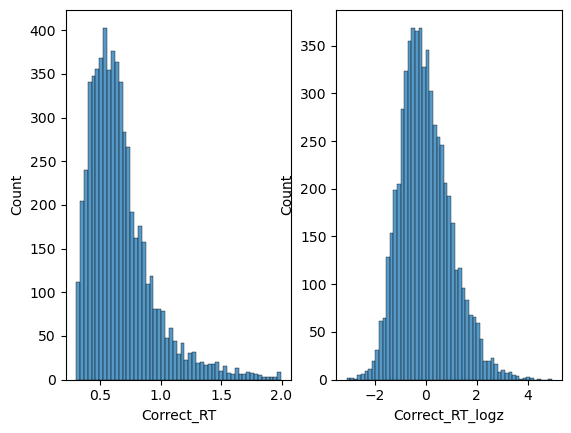

In [50]:
fig, axes = plt.subplots(1, 2)
sns.histplot(data=rt_data_mod, x='Correct_RT', ax=axes[0])
sns.histplot(data=rt_data_mod, x='Correct_RT_logz', ax=axes[1])

***

# Reaction Time Analyses

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Run and Reaction Time

In [52]:
model_run = ols('Correct_RT_logz ~ Run', data=rt_data_mod, 
                missing='drop').fit()
print(sm.stats.anova_lm(model_run, typ=2))

               sum_sq      df          F        PR(>F)
Run         70.281246     3.0  23.686973  3.094739e-15
Residual  5974.718754  6041.0        NaN           NaN


/var/folders/85/t_6qbb0j2pvbbd0sq3zrwbc00000gq/T/ipykernel_83410/3722269129.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(rt_data_mod, x='Run', y='Correct_RT_logz',


<Axes: xlabel='Run', ylabel='Correct_RT_logz'>

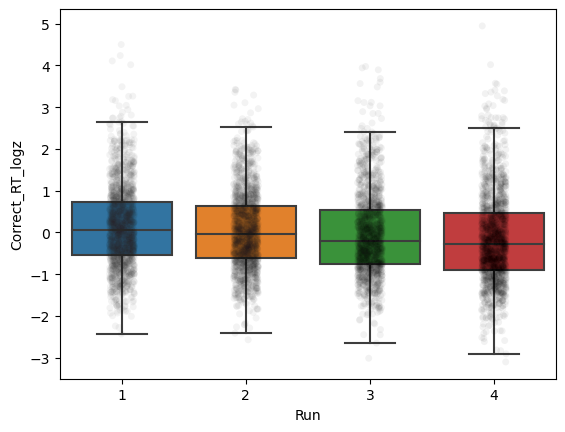

In [61]:
ax = sns.boxplot(rt_data_mod, x='Run', y='Correct_RT_logz', showfliers=False)

sns.stripplot(rt_data_mod, x='Run', y='Correct_RT_logz', 
              palette='dark:black', alpha=.05, legend=False, ax=ax, jitter=True)


## Peer Condition and Run Predicting Reaction Time

In [62]:
model_run_peer = ols('Correct_RT_logz ~ Run * C(Peer)', data=rt_data_mod, 
                missing='drop').fit()
print(sm.stats.anova_lm(model_run_peer, typ=2))

                  sum_sq      df          F        PR(>F)
Run            70.257967     3.0  23.682828  3.114379e-15
C(Peer)         2.920751     2.0   1.476807  2.284483e-01
Run:C(Peer)     5.923807     6.0   0.998410  4.243705e-01
Residual     5965.874197  6033.0        NaN           NaN


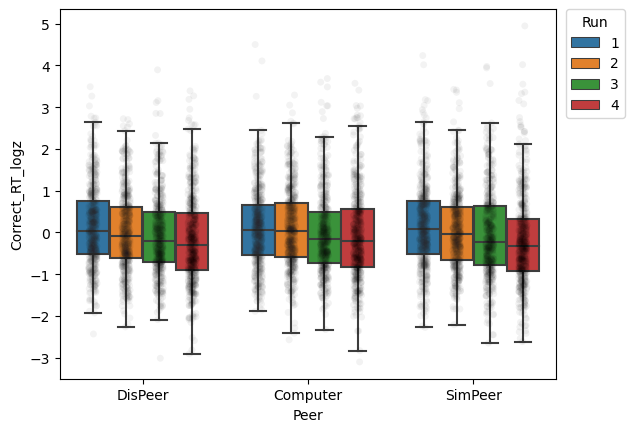

In [65]:
ax = sns.boxplot(rt_data_mod, x='Peer', y='Correct_RT_logz', hue='Run', showfliers=False)

sns.stripplot(rt_data_mod, x='Peer', y='Correct_RT_logz', hue='Run', 
              palette='dark:black', alpha=.05, legend=False, ax=ax, dodge=True)
plt.legend(bbox_to_anchor=(1.02, 1), title='Run', loc='upper left', borderaxespad=0)

# Group Analyses

## Non-Autistic Group

In [70]:
rt_data_mod_tyd = rt_data_mod[rt_data_mod['group'] == '1']
rt_data_mod_tyd

,participant_id,group,Run,ConditionName,Correct_RT,Peer,Correct_RT_log,Correct_RT_logz
0,SCN_101,1,2,HighReward_DisPeer,0.735915,DisPeer,-0.306641,-0.035638
1,SCN_101,1,2,LowReward_Computer,0.897369,Computer,-0.108288,0.647960
2,SCN_101,1,2,HighReward_SimPeer,1.268269,SimPeer,0.237653,1.840202
3,SCN_101,1,2,HighReward_Computer,0.775542,Computer,-0.254194,0.145116
4,SCN_101,1,2,HighReward_Computer,1.093963,Computer,0.089807,1.330670
...,...,...,...,...,...,...,...,...
6137,SCN_234,1,3,HighReward_DisPeer,0.428082,DisPeer,-0.848440,-0.345286
6138,SCN_234,1,3,HighReward_SimPeer,0.494318,SimPeer,-0.704576,0.237772
6139,SCN_234,1,3,HighReward_SimPeer,0.359078,SimPeer,-1.024215,-1.057670
6140,SCN_234,1,3,HighReward_DisPeer,0.473353,DisPeer,-0.747914,0.062130


In [72]:
model_run_peer_tyd = ols('Correct_RT_logz ~ Run * C(Peer)', data=rt_data_mod_tyd).fit()
print(sm.stats.anova_lm(model_run_peer_tyd, typ=2))

                  sum_sq      df          F        PR(>F)
Run            72.113238     3.0  24.494347  1.059355e-15
C(Peer)         4.707850     2.0   2.398638  9.097217e-02
Run:C(Peer)     9.794390     6.0   1.663406  1.257940e-01
Residual     3927.398498  4002.0        NaN           NaN


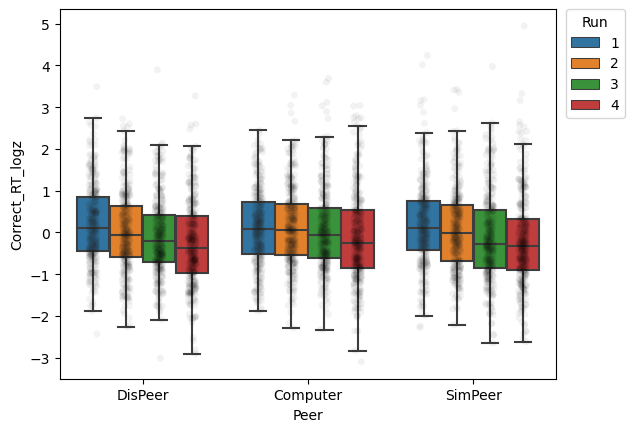

In [74]:
ax = sns.boxplot(rt_data_mod_tyd, x='Peer', y='Correct_RT_logz', hue='Run', showfliers=False)

sns.stripplot(rt_data_mod_tyd, x='Peer', y='Correct_RT_logz', hue='Run', 
              palette='dark:black', alpha=.05, legend=False, ax=ax, dodge=True)
plt.legend(bbox_to_anchor=(1.02, 1), title='Run', loc='upper left', borderaxespad=0)

## ASD Group

In [75]:
rt_data_mod_asd = rt_data_mod[rt_data_mod['group'] == '2']
rt_data_mod_asd

,participant_id,group,Run,ConditionName,Correct_RT,Peer,Correct_RT_log,Correct_RT_logz
380,SCN_105,2,3,HighReward_DisPeer,0.428253,DisPeer,-0.848041,-0.366011
381,SCN_105,2,3,LowReward_Computer,1.030081,Computer,0.029637,2.371334
382,SCN_105,2,3,HighReward_SimPeer,0.400649,SimPeer,-0.914670,-0.573816
383,SCN_105,2,3,HighReward_Computer,0.338319,Computer,-1.083767,-1.101204
384,SCN_105,2,3,HighReward_Computer,0.780494,Computer,-0.247828,1.505962
...,...,...,...,...,...,...,...,...
5847,SCN_223,2,1,LowReward_DisPeer,1.175249,DisPeer,0.161480,1.588888
5848,SCN_223,2,1,HighReward_SimPeer,0.664671,SimPeer,-0.408463,-0.387813
5849,SCN_223,2,1,HighReward_Computer,0.543963,Computer,-0.608873,-1.082883
5850,SCN_223,2,1,LowReward_DisPeer,1.097434,DisPeer,0.092975,1.351297


In [76]:
model_run_peer_asd = ols('Correct_RT_logz ~ Run * C(Peer)', data=rt_data_mod_asd).fit()
print(sm.stats.anova_lm(model_run_peer_asd, typ=2))

                  sum_sq      df         F    PR(>F)
Run             7.031746     3.0  2.348056  0.070833
C(Peer)         0.017980     2.0  0.009006  0.991035
Run:C(Peer)     8.511628     6.0  1.421111  0.202610
Residual     2015.439483  2019.0       NaN       NaN


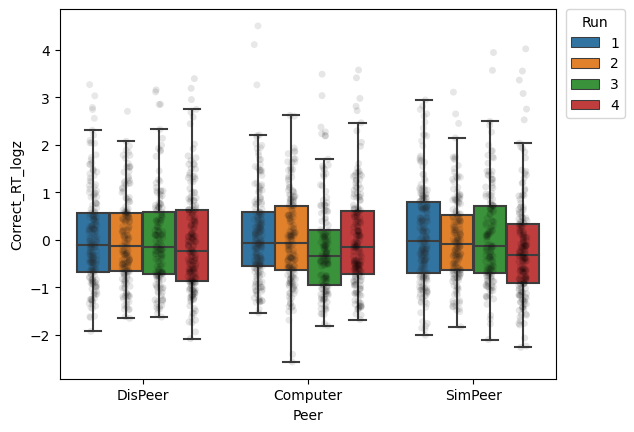

In [77]:
ax = sns.boxplot(rt_data_mod_asd, x='Peer', y='Correct_RT_logz', hue='Run', showfliers=False)

sns.stripplot(rt_data_mod_asd, x='Peer', y='Correct_RT_logz', hue='Run', 
              palette='dark:black', alpha=.1, legend=False, ax=ax, dodge=True)
plt.legend(bbox_to_anchor=(1.02, 1), title='Run', loc='upper left', borderaxespad=0)

**Results:** In the ASD group, there was no relationship between the type of peer, run number, and log reaction times. ASD participants seem to be responding similarily throughout the task for all conditions and all runs. 

## TD vs ASD
Finally, we well test for group differences.

In [78]:
# Create new variable to capture run and group for the hue in the bar plot
rt_data_mod['Run_group'] = rt_data_mod['Run'].astype('str') + '_' + rt_data_mod['group'].astype('str')

In [79]:
sns.color_palette('tab10', 4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [80]:
sns.color_palette('pastel', 4)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019)]

In [81]:
palette_a = sns.color_palette('tab10', 4).as_hex()
palette_b = sns.color_palette('pastel', 4).as_hex()

palette_c = [None]*(len(palette_a)+len(palette_b))
palette_c[::2] = palette_a
palette_c[1::2] = palette_b
palette_c

['#1f77b4',
 '#a1c9f4',
 '#ff7f0e',
 '#ffb482',
 '#2ca02c',
 '#8de5a1',
 '#d62728',
 '#ff9f9b']

In [82]:
model_run_peer_group = ols('Correct_RT_logz ~ C(Peer) * Run * group', data=rt_data_mod).fit()
print(sm.stats.anova_lm(model_run_peer_group, typ=2))

                        sum_sq      df          F        PR(>F)
C(Peer)               2.942542     2.0   1.490621  2.253157e-01
Run                  70.296793     3.0  23.740453  2.863856e-15
group                 0.004451     1.0   0.004509  9.464643e-01
C(Peer):Run           5.900794     6.0   0.996400  4.257241e-01
C(Peer):group         1.721502     2.0   0.872072  4.181373e-01
Run:group             8.887584     3.0   3.001492  2.931087e-02
C(Peer):Run:group    12.405225     6.0   2.094730  5.059044e-02
Residual           5942.837982  6021.0        NaN           NaN


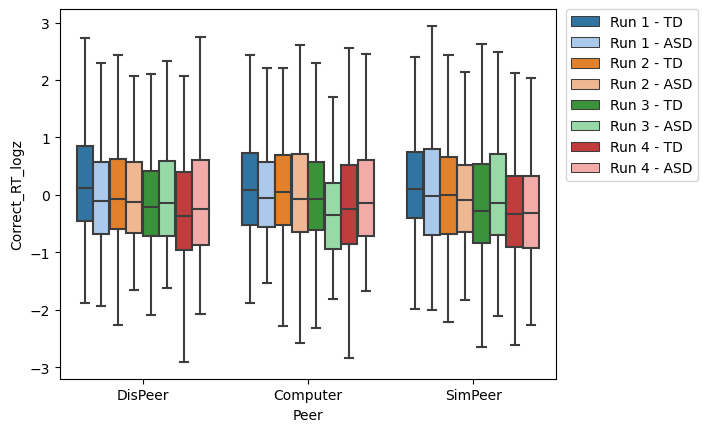

In [84]:
ax = sns.boxplot(rt_data_mod, x='Peer', y='Correct_RT_logz', hue='Run_group', showfliers=False,
                hue_order = ['1_1', '1_2', '2_1', '2_2',
                         '3_1', '3_2', '4_1', '4_2'],
            palette=palette_c)


handler, label = ax.get_legend_handles_labels()
ax.legend(handler, ['Run 1 - TD', 'Run 1 - ASD', 'Run 2 - TD', 'Run 2 - ASD',
                   'Run 3 - TD', 'Run 3 - ASD', 'Run 4 - TD', 'Run 4 - ASD'],
          bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,
           fontsize=10)

**Figure note:** Bolder colors = TD, pastel colors = ASD

***
# Reinforcement Learning Modeling

In [86]:
np.range(-5,5)

AttributeError: module 'numpy' has no attribute 'range'

In [85]:
T = 96
K = 2
mu = [0.25, 0.75]

,participant_id,group,Run,ConditionName,Correct_RT,Peer
0,SCN_101,1,2,HighReward_DisPeer,0.735915,DisPeer
1,SCN_101,1,2,LowReward_Computer,0.897369,Computer
2,SCN_101,1,2,HighReward_SimPeer,1.268269,SimPeer
3,SCN_101,1,2,HighReward_Computer,0.775542,Computer
4,SCN_101,1,2,HighReward_Computer,1.093963,Computer
...,...,...,...,...,...,...
91,SCN_101,1,4,LowReward_DisPeer,1.229602,DisPeer
92,SCN_101,1,4,HighReward_SimPeer,0.657721,SimPeer
93,SCN_101,1,4,HighReward_Computer,0.673613,Computer
94,SCN_101,1,4,LowReward_DisPeer,0.643297,DisPeer
